# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Final Project Milestone 2


**Harvard University**<br/>
**Spring 2025**<br/>
**Team**: Amar Boparai, Andrew Lobo, Conrad Kaminski, Xiaoxuan Zhang, Xuanthe Nguyen

<hr style="height:2pt">

### The Dataset

We are using the unprocessed version of the Jigsaw Unintended Bias in Toxicity Classification dataset (jigsaw-unintended-bias-train.csv) that we obtained from [Kaggle](https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification). 

This dataset contains approximately 3 million user comments posted on the Civil Comments platform or Wikipedia talk page talk page edits. Each comment is annotated with toxicity scores across multiple categories, including *toxic, severe_toxicity, obscene, insult, identity_attack,* and *threat*.

The dataset also includes demographic annotations, which demonstrate how much of each comment refers to a specific identity (*female, black, muslim*, etc). The total dataset size is around 820 MB

While the original dataset includes both raw and preprocessed versions, we are working with the raw data so that we can have full control over preprocessing: text cleaning, tokenization, truncation, and formatting. This approach will provide us more flexibility to optimize our model performance.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # For optional color mapping
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import csv
import os
%matplotlib inline

### Loading Data

In [2]:
df = pd.read_csv("data/ms2_data.csv")
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902194 entries, 0 to 1902193
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   comment_text                         object 
 2   toxic                                float64
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.902194e+06,1902191,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,426707.000000,426707.000000,...,1.902194e+06,1902194,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06
unique,NaN,1876467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Well said.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,approved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1775959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.912771e+06,NaN,1.030068e-01,4.585531e-03,1.388516e-02,2.259572e-02,8.117227e-02,9.298498e-03,0.011905,0.003362,...,2.811915e+05,NaN,2.777982e-01,4.429990e-02,1.090688e-01,2.443550e+00,5.824227e-01,6.595598e-03,1.435714e+00,8.782232e+00
std,2.497349e+06,NaN,1.970813e-01,2.286902e-02,6.465998e-02,7.863447e-02,1.760987e-01,4.939469e-02,0.086914,0.051648,...,1.040056e+05,NaN,1.054929e+00,2.457508e-01,4.563106e-01,4.720064e+00,1.861857e+00,4.525432e-02,1.774053e+01,4.338458e+01
min,5.984800e+04,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,2.006000e+03,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,8.273542e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,1.600630e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.282205e+06,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,3.320280e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.862735e+06,NaN,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,...,3.662350e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00


In [3]:
print("Shape:", df.shape)

Shape: (1902194, 45)


### EDA

To understand our data better, we do an initial missingness analysis of all columns.

In [4]:
missing_summary = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)
missing_df


,Missing Count,Missing %
latino,1475487,77.567640
white,1475487,77.567640
psychiatric_or_mental_illness,1475487,77.567640
physical_disability,1475487,77.567640
other_sexual_orientation,1475487,77.567640
other_religion,1475487,77.567640
other_race_or_ethnicity,1475487,77.567640
other_gender,1475487,77.567640
other_disability,1475487,77.567640
muslim,1475487,77.567640


We notice that the  missinginess is most present in the identity columns. This is because only a subset of the comments have been labeled with identity attributes.

These identity columns will be used only to evaluate the fairness of the model after training, not to train the model itself. In other words, we can train the model on the non-identity inputs and evaluate the bias of the model later using the identity columns. 

Before addressing the missingness of the variables we plan to include, we'll subset the data to include only what we will input to our model.

### Subsetting Dataset

Here, we subset to only include relevant columns. We remove identity columns, as mentioned above, and we also remove columns related to metadata (such as *id, publication_id, article_id,* etc) because they are not useful for toxicity prediction.

Other columns (*likes, funny, sad, wow*) may tell us about user sentiment but are not immediately useful for toxicity prediction.

We subset to a dataset with just the input and outputs. The input to our model is *comment_text*, and the outputs we will predict are *toxic, severe_toxicity, obscene, identity_attack, insult, threat, sexual_explicit*

In [5]:
cols = ['id', 'comment_text', 'toxic', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
df_subset = df[cols]

### Missingness

We now examine the missingness of the subsetted dataset

In [6]:
missing_summary = df_subset.isnull().sum()
missing_percent = (df_subset.isnull().sum() / len(df_subset)) * 100

missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)
missing_df

,Missing Count,Missing %
comment_text,3,0.000158


In [7]:
df_missing_comment_text = df[df['comment_text'].isna()]
df_missing_comment_text.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
513346,872115,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,163140,approved,5,0,0,9,1,0.0,0,4
1010795,5353666,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,340316,approved,0,0,0,0,0,0.0,4,4
1512317,5971919,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,378393,approved,0,0,0,1,0,0.0,4,4


It looks like there is no missing data outside of 3 observations where there is no comment_text. Since the dataset is so large, we can drop these three observations.

In [8]:
len(df_subset)

1902194

In [9]:
df_cleaned = df_subset.dropna(subset=['comment_text'])

In [10]:
len(df_cleaned)

1902191

### Examining Imbalance

In [11]:
label_cols = ['toxic', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

# Convert all to numeric
for col in label_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# From *Kaggle*: If >0.5 --> 1; If <0.5 --> 0
for col in label_cols:
    df_cleaned[col] = df_cleaned[col].apply(lambda x: 1 if x >= 0.5 else 0)

# Print
for col in label_cols:
    print(f"\n{col.upper()} distribution:")
    print(df_cleaned[col].value_counts())


/var/folders/6r/ywxm_hr95d3_b__w0dw6q_7r0000gn/T/ipykernel_9425/2954108152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
/var/folders/6r/ywxm_hr95d3_b__w0dw6q_7r0000gn/T/ipykernel_9425/2954108152.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].apply(lambda x: 1 if x >= 0.5 else 0)



TOXIC distribution:
toxic
0    1750080
1     152111
Name: count, dtype: int64

SEVERE_TOXICITY distribution:
severe_toxicity
0    1902178
1         13
Name: count, dtype: int64

OBSCENE distribution:
obscene
0    1892045
1      10146
Name: count, dtype: int64

IDENTITY_ATTACK distribution:
identity_attack
0    1888094
1      14097
Name: count, dtype: int64

INSULT distribution:
insult
0    1789881
1     112310
Name: count, dtype: int64

THREAT distribution:
threat
0    1897690
1       4501
Name: count, dtype: int64

SEXUAL_EXPLICIT distribution:
sexual_explicit
0    1897265
1       4926
Name: count, dtype: int64


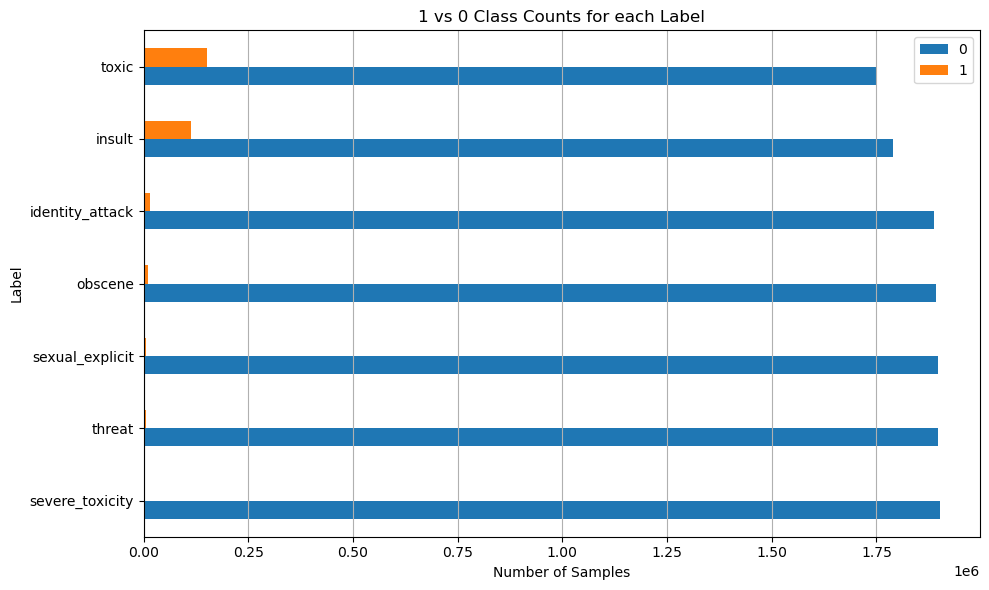

In [12]:
## AI Assistance for graphing here - ChatGPT showed us to make a dataframe and transpose it
labels_for_graphing = ['toxic', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

label_distributions = {
    col: df_cleaned[col].value_counts() for col in labels_for_graphing
}

dist_df = pd.DataFrame(label_distributions).T
dist_df.columns = ['0', '1']
dist_df = dist_df.sort_values('1')

# plot
dist_df.plot(kind='barh', stacked=False, figsize=(10, 6))
plt.title("1 vs 0 Class Counts for each Label")
plt.xlabel("Number of Samples")
plt.grid(axis='x')
plt.ylabel("Label")
plt.tight_layout()


plt.show()

Here, we see very high levels of imbalance in our cleaned dataframe. This isn't great because that means a model could just predict '0' and be correct 97% of the time in most cases. 

We aim to address these imbalances using resampling methods:

One resampling method we might consider is **oversampling the minority class**. While this may work for *toxic* and *insult*, it is unlikely to be a good method for the more extreme cases of imbalances seen in other output variables. We could also **undersample the majority class**; however, this would significantly reduce the training data we have. We are unlikely to use this approach. We will not use **SMOTE** because we are dealing with text data.

(AI Assitance for this part:) We can also use **class weights**, which basically tells the model to pay more attention to the minority class because it's underrepresented.

One last strategy we will consider is combining the some of the outputs. For example, there are only 13 observations that are observed as *severe_toxicity*. We could combine all toxicity metrics into one binary variable.

### Feature Scaling

Feature scaling is not necessary for our dataset since we are dealing with raw text data and using BERT/GPT models. Furthermore, our target labels are all float values between 0 and 1 and do not require scaling either. 

### Final Dataset

In [13]:
df_cleaned.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0
3,59855,Is this something I'll be able to install on m...,0,0,0,0,0,0,0
4,59856,haha you guys are a bunch of losers.,1,0,0,0,1,0,0


Here are the first 5 observations of our cleaned dataset, which includes the input *comment_text* and several output features all between 0 and 1. 

In this milestone, we focused on understanding our data and subsetting our dataset to only include useful variables for model training. We discovered extreme levels of imbalance and discussed several ways to address them. In our next milestone, we will experiment with various methods to address this imbalance.

In [14]:
df_cleaned.to_csv("data/cleaned_ms2_data.csv", index=False)
